# Weather-weed pressure model

In [175]:
# Import packages
import json
import pandas as pd
import urllib.request
import urllib.error
import time
import requests
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math
#from scipy.optimize import leastsq
from scipy.optimize import least_squares
import scipy.interpolate
import matplotlib.pyplot as plt

In [176]:
# Default parameters
Tbase=15 # Base temperature to compute GDD
a=1      # Maximum relative cumulative emergence

### Data wrangling - US datasets

In [177]:
from_trials=pd.read_excel('AllWeeds_Corn_US.xlsx', usecols='A, O, P, C, J, k, E')
from_trials

,trial_id,stg_date,scientific_name,pest_stage_majority_percent,pest_stage_minimum_percent,Lat,Long
0,US2G0H2002022,2022-05-18,Sicyos angulatus,NaN,NaN,40.118172,-76.426475
1,US2G0H2002022,2022-06-14,Sicyos angulatus,NaN,NaN,40.118172,-76.426475
2,US2G0H2002022,2022-06-22,Sicyos angulatus,NaN,NaN,40.118172,-76.426475
3,US2G0H2012021,2021-05-12,annual grass weeds,NaN,NaN,42.709352,-84.465842
4,US2G0H2012021,2021-06-02,annual grass weeds,NaN,NaN,42.709352,-84.465842
...,...,...,...,...,...,...,...
52857,USZY0H0162021,2021-11-27,Setaria faberi,85.0,NaN,27.728881,-80.451676
52858,USZY0H0172021,2021-11-01,Echinochloa crus-galli,100.0,NaN,27.728588,-80.451779
52859,USZY0H0172021,2021-11-01,Eleusine indica,100.0,NaN,27.728588,-80.451779
52860,USZY0H0172021,2021-11-01,Panicum dichotomiflorum,100.0,NaN,27.728588,-80.451779


In [178]:
from_trials=from_trials.drop_duplicates()

In [179]:
# Discard trials with no information for pest_stage_majority_percent and pest_stage_minimum_percent
from_trials=from_trials.dropna(subset=['pest_stage_majority_percent','pest_stage_minimum_percent'])

In [180]:
# Get year
from_trials['Year']=from_trials['stg_date'].dt.year

In [181]:
# Rename columns
from_trials=from_trials.rename(columns={'stg_date':'Date','pest_stage_majority_percent':'pest_maj','pest_stage_minimum_percent':'pest_min','Lat':'latitude','Long':'longitude'})

In [182]:
# Select the species
### Amaranthus Genus
#from_trials=from_trials[(from_trials["scientific_name"].str.contains("Amaranthus", case=False)==True)].reset_index(drop=True)

### Amaranthus Retroflexus
from_trials=from_trials[(from_trials["scientific_name"].str.contains("Retroflexus", case=False)==True)].reset_index(drop=True)
from_trials

,trial_id,Date,scientific_name,pest_maj,pest_min,latitude,longitude,Year
0,USEC0H0992011,2011-08-05,AMARANTHUS RETROFLEXUS,0.0,0.0,43.194250,-76.921550,2011
1,USEC0H1022015,2015-06-18,AMARANTHUS RETROFLEXUS,75.0,25.0,43.199970,-76.079720,2015
2,USEC0H1042013,2013-05-29,AMARANTHUS RETROFLEXUS,50.0,25.0,43.193420,-76.921290,2013
3,USNC0H0022018,2018-05-31,AMARANTHUS RETROFLEXUS,50.0,50.0,42.568130,-89.545420,2018
4,USNC0H0022022,2022-06-12,Amaranthus retroflexus,100.0,100.0,43.453510,-89.823960,2022
5,USNC0H0052019,2019-06-07,Amaranthus retroflexus,100.0,100.0,43.453530,-89.821600,2019
6,USNC0H0062016,2016-06-07,AMARANTHUS RETROFLEXUS,60.0,30.0,42.568290,-89.545220,2016
7,USNC0H0062016,2016-06-14,AMARANTHUS RETROFLEXUS,80.0,10.0,42.568290,-89.545220,2016
8,USNC0H0072016,2016-06-14,AMARANTHUS RETROFLEXUS,80.0,20.0,42.568290,-89.545220,2016
9,USNC0H0092020,2020-05-09,Amaranthus retroflexus,100.0,100.0,42.568200,-89.545700,2020


In [183]:
from_trials.trial_id=from_trials.trial_id+'_' + from_trials.scientific_name

In [184]:
# Ignore trials with less than two entries
from_trials=from_trials[from_trials.groupby(by=['trial_id']).trial_id.transform('count') > 1]

In [185]:
# Info for each trial
from_trials=from_trials.sort_values(by=['trial_id','Date'])

trials_unique=from_trials[['trial_id','latitude','longitude','Year']]
trials_unique["Start"] = pd.to_datetime(dict(year=trials_unique.Year, month=4, day=1))
trials_unique=trials_unique.drop_duplicates(subset=['trial_id'])

temp=from_trials[['trial_id','latitude','longitude','Date']]
temp=temp.groupby(by=['trial_id','latitude','longitude']).last().reset_index()
temp=temp.rename(columns={'Date':'End'})
trials_unique=trials_unique.merge(temp)

temp=from_trials[['trial_id','latitude','longitude','Date']]
temp=temp.groupby(by=['trial_id','latitude','longitude']).count().reset_index()
temp=temp.rename(columns={'Date':'Count'})
trials_unique=trials_unique.merge(temp)

trials_unique.head(50)

C:\Users\s1066915\AppData\Local\Temp/ipykernel_13040/2290055784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_unique["Start"] = pd.to_datetime(dict(year=trials_unique.Year, month=4, day=1))


,trial_id,latitude,longitude,Year,Start,End,Count
0,USNC0H0062016_AMARANTHUS RETROFLEXUS,42.568290,-89.54522,2016,2016-04-01,2016-06-14,2
1,USNC0H0092020_Amaranthus retroflexus,42.568200,-89.54570,2020,2020-04-01,2020-06-12,2
2,USNK0H0502011_AMARANTHUS RETROFLEXUS,39.859447,-83.67612,2011,2011-04-01,2011-06-30,2
3,USNK0H4042022_Amaranthus retroflexus,39.859990,-83.66991,2022,2022-04-01,2022-06-03,2
4,USNKSH680890062011_AMARANTHUS RETROFLEXUS,39.860000,-83.66985,2011,2011-04-01,2011-06-27,2
5,USNKSH690890072011_AMARANTHUS RETROFLEXUS,39.859440,-83.67458,2011,2011-04-01,2011-06-27,2
6,USNP0H1022013_AMARANTHUS RETROFLEXUS,40.482166,-104.48545,2013,2013-04-01,2013-06-18,2


In [186]:
# For the first observation use pest_min and for the following pest_maj
from_trials_first=from_trials.groupby(by=['trial_id']).first().reset_index()

from_trials_next = from_trials.merge(from_trials_first.drop_duplicates(), on=['trial_id','Date'], 
                   how='left', indicator=True)
from_trials_next=from_trials_next[from_trials_next['_merge'] == 'left_only']
from_trials_next=from_trials_next[['trial_id','Date','pest_maj_x']]
from_trials_first=from_trials_first[['trial_id','Date','pest_min']]
from_trials_next=from_trials_next.rename(columns={'pest_maj_x':'BBCH'})
from_trials_first=from_trials_first.rename(columns={'pest_min':'BBCH'})
from_trials_last=pd.concat([from_trials_first,from_trials_next])
from_trials_last

,trial_id,Date,BBCH
0,USNC0H0062016_AMARANTHUS RETROFLEXUS,2016-06-07,30.0
1,USNC0H0092020_Amaranthus retroflexus,2020-05-09,100.0
2,USNK0H0502011_AMARANTHUS RETROFLEXUS,2011-06-21,0.0
3,USNK0H4042022_Amaranthus retroflexus,2022-05-24,10.0
4,USNKSH680890062011_AMARANTHUS RETROFLEXUS,2011-06-21,33.0
5,USNKSH690890072011_AMARANTHUS RETROFLEXUS,2011-06-09,33.0
6,USNP0H1022013_AMARANTHUS RETROFLEXUS,2013-05-27,10.0
1,USNC0H0062016_AMARANTHUS RETROFLEXUS,2016-06-14,80.0
3,USNC0H0092020_Amaranthus retroflexus,2020-06-12,50.0
5,USNK0H0502011_AMARANTHUS RETROFLEXUS,2011-06-30,0.0


In [187]:
from_trials_last=from_trials_last.rename(columns={'BBCH':'Observed emergence'})

### Data wrangling - CH datasets

In [158]:
# Read the experiment file
from_trials=pd.read_excel('Weed_CH_Mio150.xlsx', header=1, usecols='A, B, D, E, H, Q, S, O')
from_trials
from_trials=from_trials.rename(columns={'stg_date':'Date'})
from_trials.trial_id=from_trials.trial_id+'_' + from_trials.pest_latin

In [159]:
from_trials=from_trials.drop_duplicates()

In [160]:
# Ignore trials with less than two entries
from_trials=from_trials[from_trials.groupby(by=['trial_id']).trial_id.transform('count') > 1]

In [161]:
# Ignore trials with less than two entries
from_trials=from_trials[from_trials.groupby(by=['trial_id']).trial_id.transform('count') > 1]

In [162]:
# Info for each trial
from_trials=from_trials.sort_values(by=['trial_id','Date'])

trials_unique=from_trials[['trial_id','latitude','longitude','Year']]
trials_unique["Start"] = pd.to_datetime(dict(year=trials_unique.Year, month=4, day=1))
trials_unique=trials_unique.drop_duplicates(subset=['trial_id'])

temp=from_trials[['trial_id','latitude','longitude','Date']]
temp=temp.groupby(by=['trial_id','latitude','longitude']).last().reset_index()
temp=temp.rename(columns={'Date':'End'})
trials_unique=trials_unique.merge(temp)

temp=from_trials[['trial_id','latitude','longitude','Date']]
temp=temp.groupby(by=['trial_id','latitude','longitude']).count().reset_index()
temp=temp.rename(columns={'Date':'Count'})
trials_unique=trials_unique.merge(temp)

trials_unique.head(50)

C:\Users\s1066915\AppData\Local\Temp/ipykernel_13040/2290055784.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_unique["Start"] = pd.to_datetime(dict(year=trials_unique.Year, month=4, day=1))


,trial_id,latitude,longitude,Year,Start,End,Count
0,CHMS0H2002021_Amaranthus retroflexus,47.567547,7.827225,2021,2021-04-01,2021-07-20,3
1,CHMS0H2012021_Amaranthus blitoides,47.567788,7.827084,2021,2021-04-01,2021-07-28,3
2,CHMS0H2012021_Amaranthus retroflexus,47.567788,7.827084,2021,2021-04-01,2021-07-28,3
3,CHMS0H2032019_AMARANTHUS RETROFLEXUS,47.349440,7.492810,2019,2019-04-01,2019-07-05,2
4,CHMS0H2042019_AMARANTHUS RETROFLEXUS,47.347380,7.492825,2019,2019-04-01,2019-07-19,4
5,CHMS0H2042021_Amaranthus blitoides,47.567645,7.826934,2021,2021-04-01,2021-07-19,3
6,CHMS0H2042021_Amaranthus retroflexus,47.567645,7.826934,2021,2021-04-01,2021-07-19,3
7,CHMS0H2042022_Amaranthus retroflexus,47.569131,7.824456,2022,2022-04-01,2022-06-09,3
8,CHMS0H2052022_Amaranthus retroflexus,47.569097,7.824706,2022,2022-04-01,2022-06-22,3
9,CHMS0H2072019_AMARANTHUS RETROFLEXUS,47.347700,7.492662,2019,2019-04-01,2019-07-02,2


In [163]:
# For the first observation use pest_min and for the following pest_maj
from_trials_first=from_trials.groupby(by=['trial_id']).first().reset_index()

from_trials_next = from_trials.merge(from_trials_first.drop_duplicates(), on=['trial_id','Date'], 
                   how='left', indicator=True)
from_trials_next=from_trials_next[from_trials_next['_merge'] == 'left_only']
from_trials_next=from_trials_next[['trial_id','Date','pest_maj_x']]
from_trials_first=from_trials_first[['trial_id','Date','pest_min']]
from_trials_next=from_trials_next.rename(columns={'pest_maj_x':'BBCH'})
from_trials_first=from_trials_first.rename(columns={'pest_min':'BBCH'})
from_trials_last=pd.concat([from_trials_first,from_trials_next])
from_trials_last

,trial_id,Date,BBCH
0,CHMS0H2002021_Amaranthus retroflexus,2021-06-22,13.0
1,CHMS0H2012021_Amaranthus blitoides,2021-06-30,14.0
2,CHMS0H2012021_Amaranthus retroflexus,2021-06-30,14.0
3,CHMS0H2032019_AMARANTHUS RETROFLEXUS,2019-06-21,33.0
4,CHMS0H2042019_AMARANTHUS RETROFLEXUS,2019-06-14,18.0
...,...,...,...
186,CHMS0H3222019_AMARANTHUS RETROFLEXUS,2019-06-18,34.0
187,CHMS0H3222019_AMARANTHUS RETROFLEXUS,2019-07-03,55.0
188,CHMS0H3222019_AMARANTHUS RETROFLEXUS,2019-07-18,55.0
190,CHMS0H3232019_AMARANTHUS RETROFLEXUS,2019-06-18,34.0


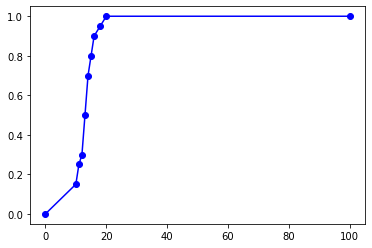

In [164]:
# Linear interpolation of BBCH curve
exp_emer=pd.read_excel('Observed_emergence.xlsx')
y_interp = scipy.interpolate.interp1d(exp_emer['BBCH'], exp_emer['Observed emergence'])
plt.plot(exp_emer['BBCH'], exp_emer['Observed emergence'], '-ob')

In [165]:
# Associate to BBCH values the corresponding value of emergence
from_trials_last['Observed emergence']=from_trials_last['BBCH'].apply( lambda x: y_interp(x))
from_trials_last

,trial_id,Date,BBCH,Observed emergence
0,CHMS0H2002021_Amaranthus retroflexus,2021-06-22,13.0,0.50
1,CHMS0H2012021_Amaranthus blitoides,2021-06-30,14.0,0.70
2,CHMS0H2012021_Amaranthus retroflexus,2021-06-30,14.0,0.70
3,CHMS0H2032019_AMARANTHUS RETROFLEXUS,2019-06-21,33.0,1.00
4,CHMS0H2042019_AMARANTHUS RETROFLEXUS,2019-06-14,18.0,0.95
...,...,...,...,...
186,CHMS0H3222019_AMARANTHUS RETROFLEXUS,2019-06-18,34.0,1.00
187,CHMS0H3222019_AMARANTHUS RETROFLEXUS,2019-07-03,55.0,1.00
188,CHMS0H3222019_AMARANTHUS RETROFLEXUS,2019-07-18,55.0,1.00
190,CHMS0H3232019_AMARANTHUS RETROFLEXUS,2019-06-18,34.0,1.00


### Retrieve soil data from the CE Hub

In [188]:
# Get soil temperature data
values="""
    {
    "units": {
        "temperature": "°C",
        "velocity": "km/h",
        "length": "metric",
        "energy": "watts"
    },
    "geometry": {
        "type": "MultiPoint",
        "coordinates": [
            [
                7.492747,
                47.34774
            ]
        ],
        "locationNames": [
            "Basel"
        ],
        "mode": "preferLandWithMatchingElevation"
    },
    "format": "json",
    "timeIntervals": [
        "2019-07-01T+00:00/2019-08-30T+00:00"
    ],
    "timeIntervalsAlignment": "none",
    "queries": [
        {
            "domain": "ERA5T",
            "gapFillDomain": null,
            "timeResolution": "daily",
            "codes": [
                {
                    "code": 85,
                    "level": "0-7 cm down",
                    "aggregation": "mean"
                }
            ]
        }
    ]
}"""

info = json.loads(values)
url = "http://my.meteoblue.com/dataset/query?apikey=syngv934nf4g3"

df_new=[]
for i in range(0,len(trials_unique)):
    print(i/len(trials_unique))
    
    info["geometry"]['coordinates'][0][0] = trials_unique['longitude'].iloc[i]
    info["geometry"]['coordinates'][0][1] = trials_unique['latitude'].iloc[i]
    time1="{date}T+00:00".format(date=trials_unique['Start'].iloc[i].date())
    time2="{date}T+00:00".format(date=trials_unique['End'].iloc[i].date())
    TimeInterval=str(time1) + '/' + str(time2)
    info["timeIntervals"][0] = TimeInterval
    
    JobRequest = urllib.request.Request(url, json.dumps(info).encode("utf-8"),
                                                            headers={'Content-type': 'application/json',
                                                                     'Accept': 'application/json'})
    try: 
        # get the job response as json object
        JobResponse = json.loads(urllib.request.urlopen(JobRequest).read())

    except urllib.error.HTTPError as e:
        print("Error: ", e)

    soil_temp=JobResponse[0]['codes'][0]['dataPerTimeInterval'][0]['data'][0]
    time=JobResponse[0]['timeIntervals'][0]
    df=pd.DataFrame(np.transpose([time,soil_temp]), columns=['Date','ST'])
    df=df.assign(trial_id=trials_unique['trial_id'].iloc[i])
    df=df.assign(latitude=trials_unique['latitude'].iloc[i])
    df=df.assign(longitude=trials_unique['longitude'].iloc[i])
    df_new.append(df)

df = pd.concat(df_new, ignore_index=True)
df['ST']=df['ST'].astype(float)
df['Date']=pd.to_datetime(df['Date'])

0.0
0.14285714285714285
0.2857142857142857
0.42857142857142855
0.5714285714285714
0.7142857142857143
0.8571428571428571


In [189]:
# Computation of GDD
df['DiffT'] =  np.where(df.ST-Tbase>0, df.ST-Tbase, 0)
df['GDD'] = df.groupby(['trial_id'])['DiffT'].cumsum()

In [190]:
# Merge trail data and soil temperature data
from_trials_last=from_trials_last.merge(df, how='left')
from_trials_last

,trial_id,Date,Observed emergence,ST,latitude,longitude,DiffT,GDD
0,USNC0H0062016_AMARANTHUS RETROFLEXUS,2016-06-07,30.0,17.100834,42.568290,-89.54522,2.100834,98.148755
1,USNC0H0092020_Amaranthus retroflexus,2020-05-09,100.0,6.921250,42.568200,-89.54570,0.000000,0.805419
2,USNK0H0502011_AMARANTHUS RETROFLEXUS,2011-06-21,0.0,22.767500,39.859447,-83.67612,7.767500,255.918751
3,USNK0H4042022_Amaranthus retroflexus,2022-05-24,10.0,16.548750,39.859990,-83.66991,1.548750,87.694590
4,USNKSH680890062011_AMARANTHUS RETROFLEXUS,2011-06-21,33.0,22.767500,39.860000,-83.66985,7.767500,255.918751
5,USNKSH690890072011_AMARANTHUS RETROFLEXUS,2011-06-09,33.0,25.699171,39.859440,-83.67458,10.699171,178.703337
6,USNP0H1022013_AMARANTHUS RETROFLEXUS,2013-05-27,10.0,25.222916,40.482166,-104.48545,10.222916,121.904155
7,USNC0H0062016_AMARANTHUS RETROFLEXUS,2016-06-14,80.0,24.415415,42.568290,-89.54522,9.415415,144.184166
8,USNC0H0092020_Amaranthus retroflexus,2020-06-12,50.0,20.070415,42.568200,-89.54570,5.070415,131.092912
9,USNK0H0502011_AMARANTHUS RETROFLEXUS,2011-06-30,0.0,22.084167,39.859447,-83.67612,7.084167,314.065009


In [191]:
# Discard trials with no lat and long
from_trials_last=from_trials_last.dropna(subset=['latitude','longitude'])

### Optimization

In [192]:
def func1(params, X, Y):
    b, x0= params[0], params[1]
    residual=np.exp(-np.exp(-(X-x0)/b))-Y
    return residual

lst_results=[]
params = [100, 100]
for s in range(0,len(trials_unique)):
    temp=from_trials_last[(from_trials_last.trial_id==trials_unique['trial_id'].iloc[s])]
    if temp['Observed emergence'].is_monotonic is True: # Disregard trials with no monotonic increasing BBCH values
        x=np.array(temp.GDD)
        y=np.array(temp['Observed emergence'])
        #result=leastsqr(func1, params, (x, y))
        result=least_squares(func1, x0=params, args=(x, y), bounds=(0,+np.inf))
        lst_results.append([trials_unique['trial_id'].iloc[s],result.x[0],result.x[1]])
df_results = pd.DataFrame(lst_results, columns=['trial_id','b','x0'])
m=df_results.mean(numeric_only=True)
s=df_results.std(numeric_only=True)
print('b: ' + str(round(m[0],2)) + '+-' + str(round(s[0],2)))
print('x0: ' + str(round(m[1],2)) + '+-' + str(round(s[1],2)))

b: 63.74+-153.91
x0: 205.55+-500.25


C:\Users\s1066915\AppData\Local\Temp/ipykernel_13040/1353270891.py:10: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if temp['Observed emergence'].is_monotonic is True: # Disregard trials with no monotonic increasing BBCH values


In [193]:
# Merge together results and trial information
df_results=df_results.merge(trials_unique, how='inner')
del df_results['Start']
del df_results['End']

In [194]:
df_results.to_csv('US_Amaranthus_Retroflexus.csv')
df_results.head(10)

,trial_id,b,x0,latitude,longitude,Year,Count
0,USNC0H0062016_AMARANTHUS RETROFLEXUS,0.598394,0.781882,42.568290,-89.54522,2016,2
1,USNK0H0502011_AMARANTHUS RETROFLEXUS,377.913236,1226.683836,39.859447,-83.67612,2011,2
2,USNK0H4042022_Amaranthus retroflexus,0.519275,0.926939,39.859990,-83.66991,2022,2
3,USNKSH680890062011_AMARANTHUS RETROFLEXUS,1.223533,1.235768,39.860000,-83.66985,2011,2
4,USNKSH690890072011_AMARANTHUS RETROFLEXUS,1.325522,1.426028,39.859440,-83.67458,2011,2
5,USNP0H1022013_AMARANTHUS RETROFLEXUS,0.884978,2.252026,40.482166,-104.48545,2013,2


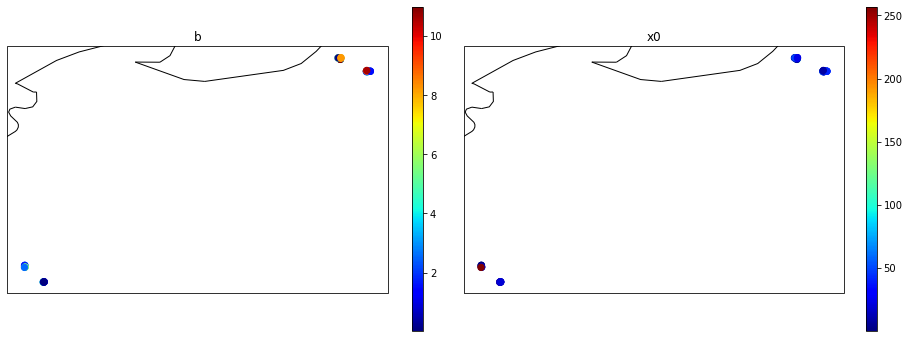

In [174]:
import cartopy.crs as ccrs
import cartopy.feature as cf

fig, axs = plt.subplots(nrows=1,ncols=2,    ### Modify here based on the number of subplots needed
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,6))     ### Modify the size of the plot

# Contour plot
cs=axs[0].scatter(df_results['longitude'],df_results['latitude'],c=df_results['b'],  
                  transform = ccrs.PlateCarree(),
                  cmap='jet', vmin=min(df_results['b']), vmax=max(df_results['b']), s=40)     ### You can modify the minimum and maximum of the colorbar
#axs[0].set_xlim([-130,7.-80])
#axs[0].set_ylim([25,50])
axs[0].add_feature(cf.COASTLINE)
axs[0].add_feature(cf.BORDERS)

# Title each subplot with the name of the model
axs[0].set_title('b')

cbar_ax = fig.add_axes([0.5, 0.13, 0.01, 0.75])                    ### You can modify the position of the colorbar
cbar = plt.colorbar(cs, cax=cbar_ax, orientation='vertical') 


# Contour plot
cs=axs[1].scatter(df_results['longitude'],df_results['latitude'],c=df_results['x0'],  
                  transform = ccrs.PlateCarree(),
                  cmap='jet', vmin=min(df_results['x0']), vmax=max(df_results['x0']), s=40)     ### You can modify the minimum and maximum of the colorbar
#axs[1].set_xlim([-130,7.-80])
#axs[1].set_ylim([25,50])
axs[1].add_feature(cf.COASTLINE)
axs[1].add_feature(cf.BORDERS)

# Title each subplot with the name of the model
axs[1].set_title('x0')

cbar_ax = fig.add_axes([0.92, 0.13, 0.01, 0.75])                    ### You can modify the position of the colorbar
cbar = plt.colorbar(cs, cax=cbar_ax, orientation='vertical')   ### You can modfiy the ticks of the colorbar

#fig.suptitle(variable + ' ,Coefficient of determination, R2 (-)', fontsize=16)
#fig.tight_layout()
fig.savefig('CH_Amaranthus.png') 

In [148]:
df_results

,trial_id,b,x0,latitude,longitude,Year,Count
0,USNC0H0062016_AMARANTHUS RETROFLEXUS,0.598394,0.781882,42.568290,-89.54522,2016,2
1,USNK0H0502011_AMARANTHUS RETROFLEXUS,377.913236,1226.683836,39.859447,-83.67612,2011,2
2,USNK0H4042022_Amaranthus retroflexus,0.519275,0.926939,39.859990,-83.66991,2022,2
3,USNKSH680890062011_AMARANTHUS RETROFLEXUS,1.223533,1.235768,39.860000,-83.66985,2011,2
4,USNKSH690890072011_AMARANTHUS RETROFLEXUS,1.325522,1.426028,39.859440,-83.67458,2011,2
5,USNP0H1022013_AMARANTHUS RETROFLEXUS,0.884978,2.252026,40.482166,-104.48545,2013,2


C:\Users\s1066915\AppData\Local\Temp/ipykernel_13040/4220052372.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2,figsize=(6,3.5))


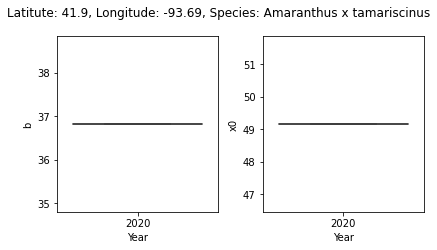

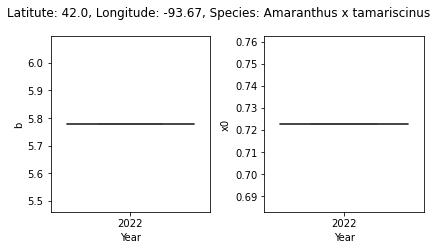

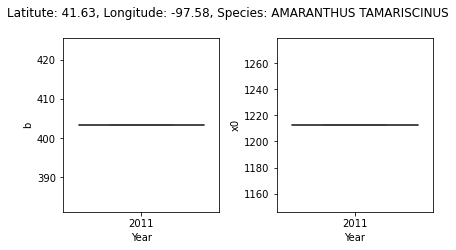

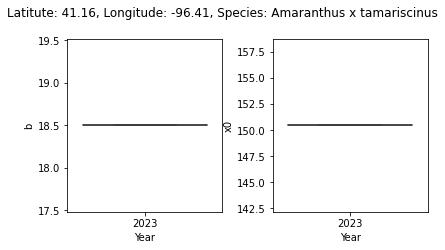

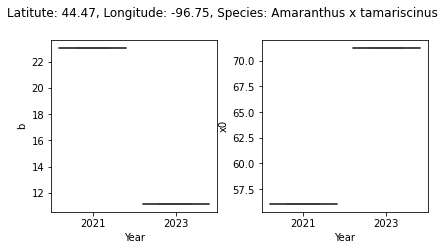

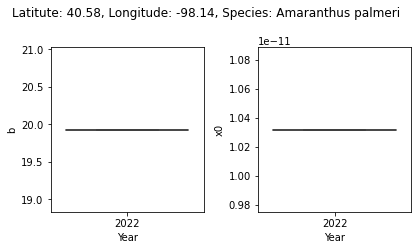

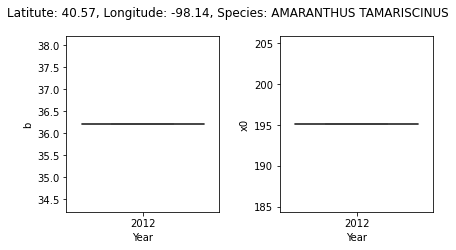

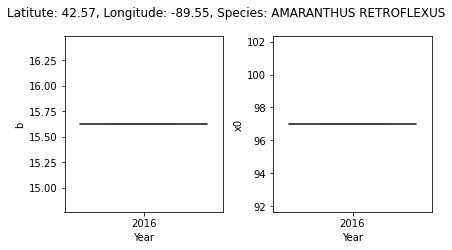

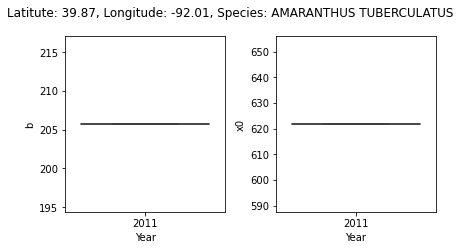

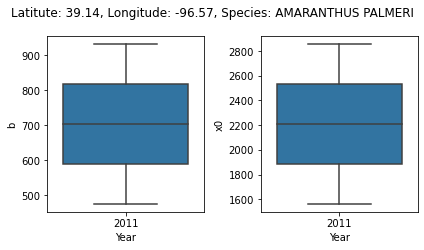

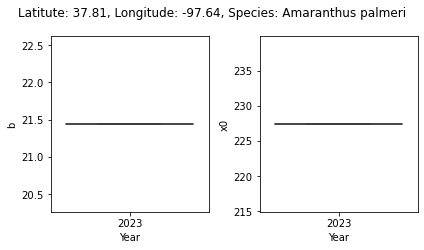

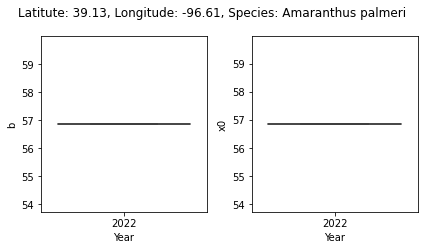

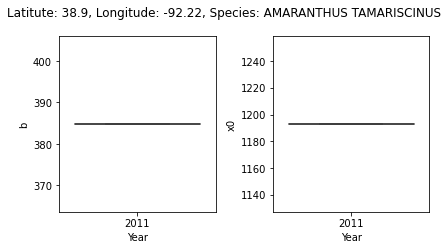

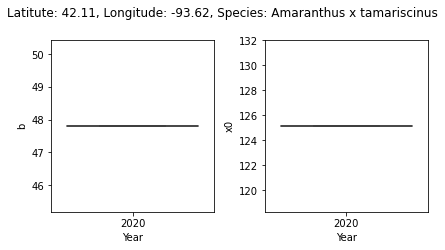

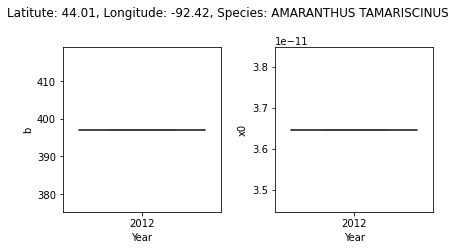

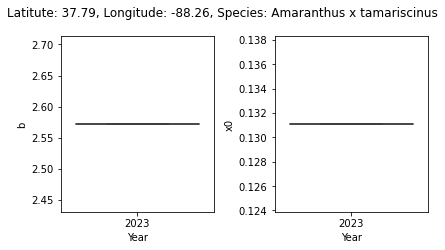

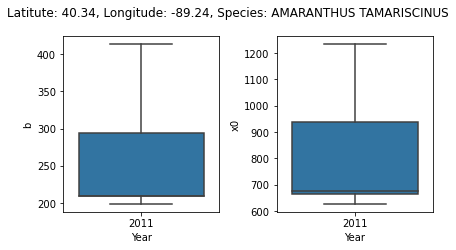

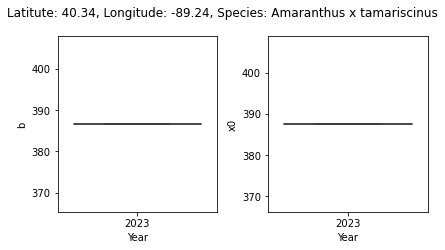

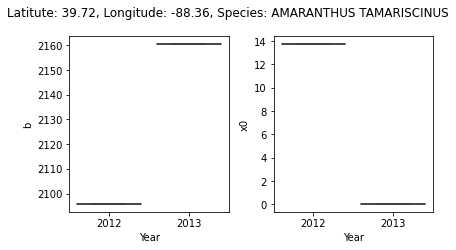

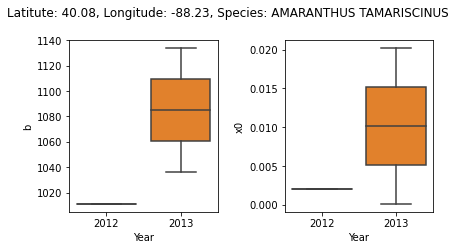

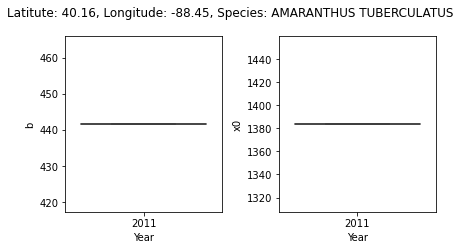

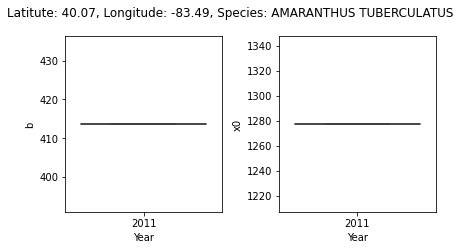

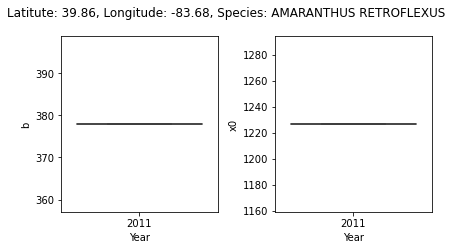

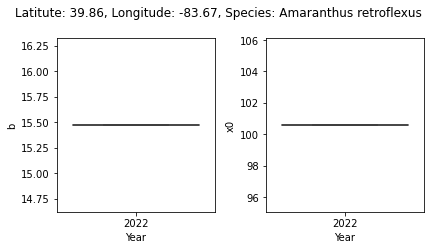

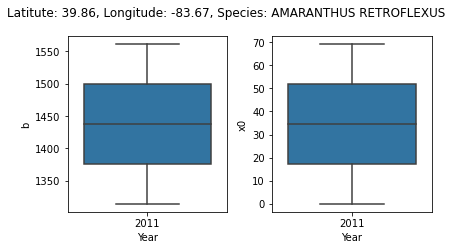

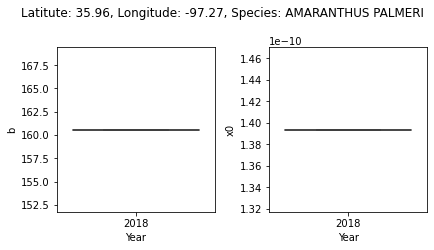

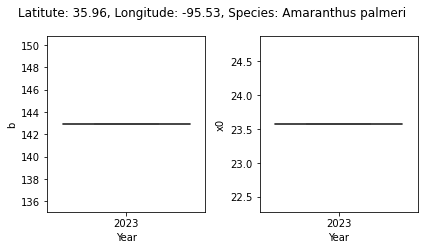

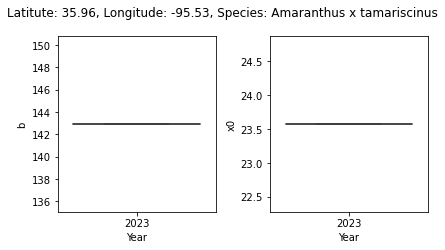

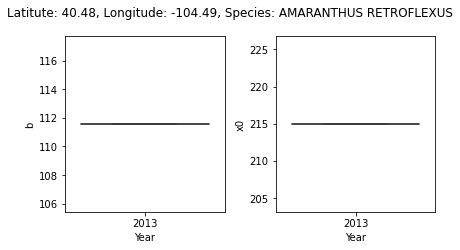

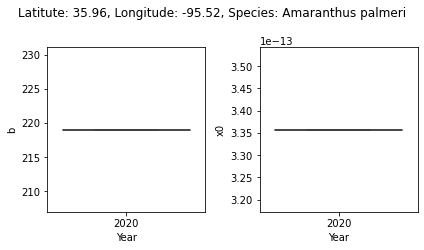

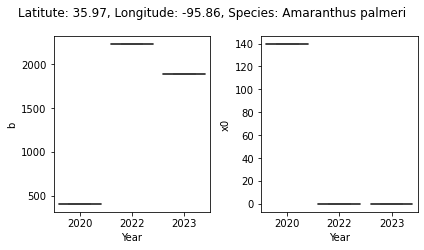

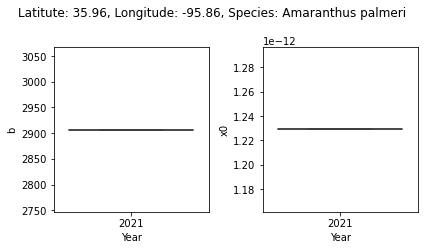

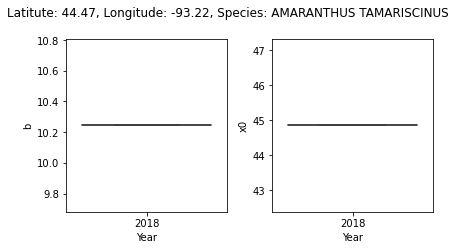

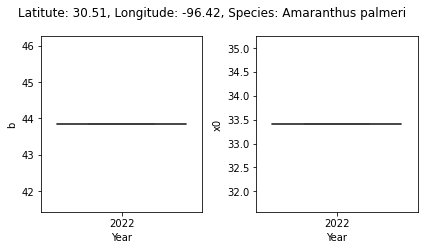

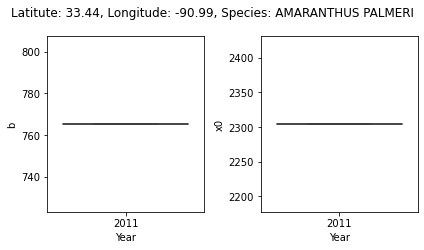

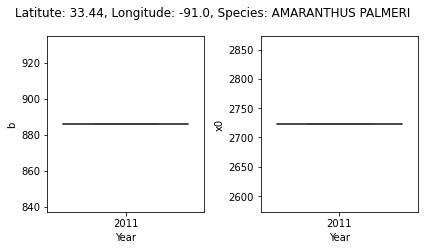

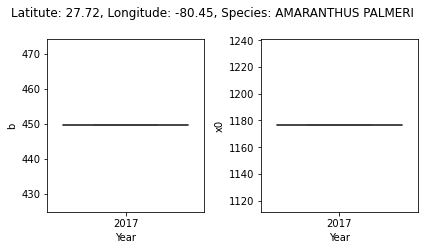

In [64]:
# Group by trials in the same locations and dispaying the values for different years
df_results['latitude']=df_results['latitude'].round(2)
df_results['longitude']=df_results['longitude'].round(2)

df_results['Species']=df_results['trial_id'].str.split('_').str.get(1)

locations=df_results[['latitude','longitude']]
locations=locations.drop_duplicates()

import seaborn as sns
for l in range(0,len(locations)):
    temp=df_results[(df_results['latitude']==locations['latitude'].iloc[l])&(df_results['longitude']==locations['longitude'].iloc[l])]
    sp=temp.Species.unique()
    for i in range(0,len(sp)):
        fig, ax = plt.subplots(1,2,figsize=(6,3.5))
        t=temp[temp.Species==sp[i]]

        sns.boxplot(x="Year", y="b", data=t, showfliers = False, ax=ax[0])

        sns.boxplot(x="Year", y="x0", data=t, showfliers = False,ax=ax[1])

        fig.suptitle('Latitute: ' + str(locations['latitude'].iloc[l]) + ', Longitude: ' + str(locations['longitude'].iloc[l]) + ', Species: ' + str(sp[i]))
        
        fig.tight_layout()
        
        fig.savefig('Latitute_' + str(locations['latitude'].iloc[l]) + '_Longitude_' + str(locations['longitude'].iloc[l]) + '_Species_' + str(i) + '.png') 